In [3]:
import os
os.chdir('../')
# enable auto-reload of sources
%load_ext autoreload
%autoreload 2
# import tensorboard backend
from tensorboard.backend.event_processing import event_accumulator

In [4]:
# set log dir of harmonized model
harm_log_dir = 'logs/harm/lightning_logs/version_5/'
raw_log_dir = 'logs/raw/lightning_logs/baba/'
raw_log_dir = 'logs/raw/lightning_logs/version_19/'

In [5]:
log_dir = raw_log_dir
# Load the event accumulator
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Check available tags (e.g., scalars, histograms, images)
tags = event_acc.Tags()

2024-12-10 14:00:33.135828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 14:00:34.665610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 14:00:34.754814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 14:00:34.870566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 14:00:36.167296: I tensorflow/core/platform/cpu_feature_guar

In [7]:
import pandas as pd

results = []
tags = [t for t in tags['scalars'] if t != 'hp_metric']
for tag in tags:
    scalar_data = event_acc.Scalars(tag)
    # Extract the step and value from the scalar data
    steps = [entry.step for entry in scalar_data]
    values = [entry.value for entry in scalar_data]
    # Store the data in the dictionary
    results.append(pd.DataFrame({'tag': tag, 'step': steps, 'value': values}))

results = pd.concat(results)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(data, mode='train',
                 targets=['cell_type_acc', 'pert_acc', 'precision', 'recall'],
                 target_labels=['Perturbation precision', 'Perturbation recall', 'Cell type accuracy', 'Perturbation accuracy'],
                 **plot_args):
    targets = [f'{mode}_{t}' for t in targets]
    df = data[data.tag.isin(targets)].copy()
    df.tag = df.tag.str.split('_').str[1:].str.join(' ')
    # plot 
    fig, ax = plt.subplots()
    ax = sns.lineplot(df, x='step', y='value', hue='tag', **plot_args)
    plt.title(f'{mode.capitalize()}. Metrics')
    plt.xlabel('Steps')
    plt.ylabel('Value')
    # Get current legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # Rename the legend labels if alternatives are given
    labels = target_labels if target_labels else labels
    # Reapply the legend with the new labels
    plt.legend(handles=handles, labels=labels, title='Metrics', bbox_to_anchor=(1.5, 0.5), loc='lower center')
    plt.tight_layout()
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5)
    plt.show()

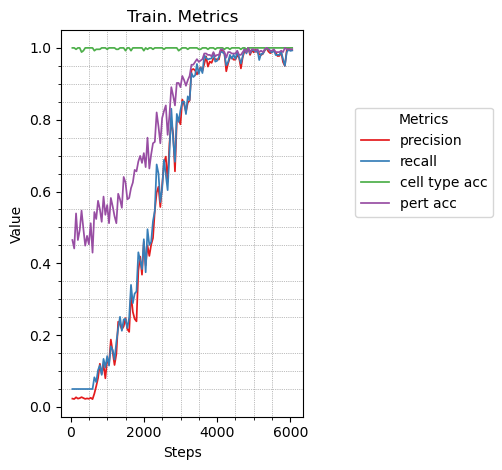

In [10]:
plot_metrics(results, mode='train', palette='Set1', target_labels=None, linewidth=1.25)

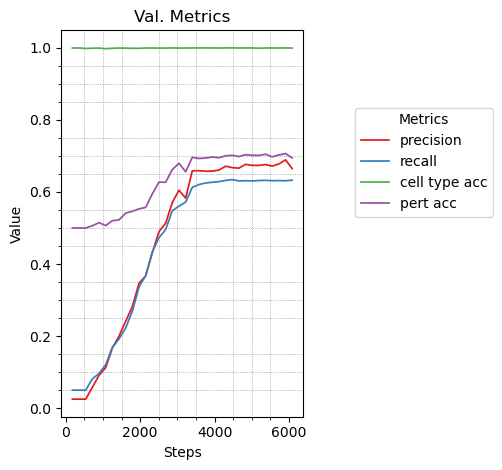

In [11]:
plot_metrics(results, mode='val', palette='Set1', target_labels=None, linewidth=1.25)

In [22]:
loss_targets = results.tag[results.tag.str.startswith('train') & results.tag.str.contains('loss')].str.split('_').str[1:].str.join(sep='_').unique()

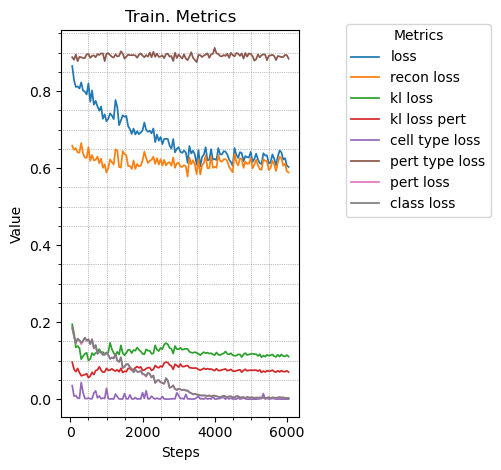

In [23]:
plot_metrics(results, mode='train',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)

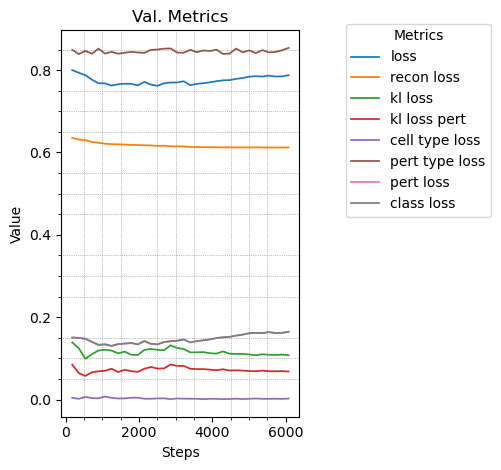

In [24]:
plot_metrics(results, mode='val',
             targets=loss_targets,
             target_labels=None, linewidth=1.25)